In [81]:
import piplite
await piplite.install('seaborn')

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [22]:
from scipy.stats import pearsonr

In [131]:
from sklearn.model_selection import train_test_split

### Loading the data

In [63]:
# load data into notebook
data = pd.read_csv("/drive/notebooks/2019SchoolData/2019_PublicDataFile_Students.csv")
data.head(5)

,DBN,School Name,Total Parent \nResponse Rate %,Total Teacher Response Rate %,Total Student Response Rate %,Collaborative Teachers Score,Effective School Leadership Score,Rigorous Instruction Score,Supportive Environment Score,Strong Family-Community Ties Score,Trust Score
0,01M015,P.S. 015 ROBERTO CLEMENTE,91,100,NaN,4.10,4.19,4.02,NaN,4.18,3.96
1,01M019,P.S. 019 ASHER LEVY,100,93,NaN,4.53,4.51,4.80,NaN,4.66,3.76
2,01M020,P.S. 020 ANNA SILVER,58,90,NaN,2.71,2.98,1.92,NaN,3.84,3.14
3,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,29,100,95.0,2.69,2.59,2.14,NaN,3.67,2.38
4,01M063,THE STAR ACADEMY - P.S.63,80,100,NaN,NaN,NaN,NaN,NaN,NaN,3.77


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829 entries, 0 to 1828
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   DBN                                 1829 non-null   object 
 1   School Name                         1829 non-null   object 
 2   Total Parent 
Response Rate %       1829 non-null   int64  
 3   Total Teacher Response Rate %       1829 non-null   int64  
 4   Total Student Response Rate %       1109 non-null   float64
 5   Collaborative Teachers Score        1625 non-null   float64
 6   Effective School Leadership Score   1625 non-null   float64
 7   Rigorous Instruction Score          1625 non-null   float64
 8   Supportive Environment Score        0 non-null      float64
 9   Strong Family-Community Ties Score  1610 non-null   float64
 10  Trust Score                         1757 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory u

### Cleaning the data

In [65]:
#drop the all NaN column 
data.drop('Supportive Environment Score', axis=1, inplace=True)

#replace NaN with 0 for 'Total Student Response Rate %' column
data['Total Student Response Rate %'] = data['Total Student Response Rate %'].fillna(0)

#replace NaN with avg for the scores : Collaborative Teachers, Effective School Leadership, Rigorous Instruction, Strong Family-Community Ties
data['Collaborative Teachers Score'] = data['Collaborative Teachers Score'].fillna(round(data['Collaborative Teachers Score'].mean(),2))
data['Effective School Leadership Score'] = data['Effective School Leadership Score'].fillna(round(data['Effective School Leadership Score'].mean(),2))
data['Rigorous Instruction Score'] = data['Rigorous Instruction Score'].fillna(round(data['Rigorous Instruction Score'].mean(),2))
data['Strong Family-Community Ties Score'] = data['Strong Family-Community Ties Score'].fillna(round(data['Strong Family-Community Ties Score'].mean(),2))
data['Trust Score'] = data['Trust Score'].fillna(round(data['Trust Score'].mean(),2))

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
data.drop_duplicates(inplace=True)

Number of duplicate rows: 0


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829 entries, 0 to 1828
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   DBN                                 1829 non-null   object 
 1   School Name                         1829 non-null   object 
 2   Total Parent 
Response Rate %       1829 non-null   int64  
 3   Total Teacher Response Rate %       1829 non-null   int64  
 4   Total Student Response Rate %       1829 non-null   float64
 5   Collaborative Teachers Score        1829 non-null   float64
 6   Effective School Leadership Score   1829 non-null   float64
 7   Rigorous Instruction Score          1829 non-null   float64
 8   Strong Family-Community Ties Score  1829 non-null   float64
 9   Trust Score                         1829 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 128.7+ KB


### Exploratory Statistics

#### Correlations between variables

In [69]:
df = pd.DataFrame(data[['Collaborative Teachers Score','Effective School Leadership Score', 'Rigorous Instruction Score', 'Strong Family-Community Ties Score', 'Trust Score']])
df.head()

,Collaborative Teachers Score,Effective School Leadership Score,Rigorous Instruction Score,Strong Family-Community Ties Score,Trust Score
0,4.10,4.19,4.02,4.18,3.96
1,4.53,4.51,4.80,4.66,3.76
2,2.71,2.98,1.92,3.84,3.14
3,2.69,2.59,2.14,3.67,2.38
4,3.67,3.61,3.59,3.74,3.77


In [71]:
# Function to calculate p-values
def calculate_p_values(df):
    cols = df.columns
    p_matrix = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)
    
    for i in range(0,len(cols)):
        for j in range(i+1, len(cols)):  # Avoid duplicate calculations
            corr, p_value = pearsonr(df[cols[i]], df[cols[j]])
            p_matrix.iloc[i, j] = p_value
            p_matrix.iloc[j, i] = p_value  # Mirror the matrix
    
    return p_matrix

In [73]:
correlation_matrix = df.corr()
correlation_matrix

,Collaborative Teachers Score,Effective School Leadership Score,Rigorous Instruction Score,Strong Family-Community Ties Score,Trust Score
Collaborative Teachers Score,1.000000,0.780627,0.744388,0.452560,0.660159
Effective School Leadership Score,0.780627,1.000000,0.594298,0.457072,0.678595
Rigorous Instruction Score,0.744388,0.594298,1.000000,0.379394,0.434924
Strong Family-Community Ties Score,0.452560,0.457072,0.379394,1.000000,0.565342
Trust Score,0.660159,0.678595,0.434924,0.565342,1.000000


In [72]:
p_value_matrix = calculate_p_values(df)
p_value_matrix

,Collaborative Teachers Score,Effective School Leadership Score,Rigorous Instruction Score,Strong Family-Community Ties Score,Trust Score
Collaborative Teachers Score,1.000000e+00,0.000000e+00,0.000000e+00,4.946586e-93,0.000000e+00
Effective School Leadership Score,0.000000e+00,1.000000e+00,0.000000e+00,4.337465e-95,0.000000e+00
Rigorous Instruction Score,0.000000e+00,0.000000e+00,1.000000e+00,1.079161e-63,2.781279e-85
Strong Family-Community Ties Score,4.946586e-93,4.337465e-95,1.079161e-63,1.000000e+00,0.000000e+00
Trust Score,0.000000e+00,0.000000e+00,2.781279e-85,0.000000e+00,1.000000e+00


p < 0.05 → Statistically significant correlation (strong evidence of a relationship). <br>
p ≥ 0.05 → No significant correlation.

In [74]:
def categorize_correlation(value):
    if value == 1:
        return "Perfect"
    elif abs(value) >= 0.7:
        return "Strong"
    elif abs(value) >= 0.4:
        return "Moderate"
    elif abs(value) >= 0.1:
        return "Weak"
    else:
        return "No"

def categorize_p_value(value):
    if value < 0.05:
        return "stat sig"
    else:
        return "no sig corr"

In [77]:
categorized_correlation_matrix = correlation_matrix.map(categorize_correlation)
categorized_p_value_matrix = p_value_matrix.map(categorize_p_value)

In [78]:
categorized_correlation_matrix 

,Collaborative Teachers Score,Effective School Leadership Score,Rigorous Instruction Score,Strong Family-Community Ties Score,Trust Score
Collaborative Teachers Score,Perfect,Strong,Strong,Moderate,Moderate
Effective School Leadership Score,Strong,Perfect,Moderate,Moderate,Moderate
Rigorous Instruction Score,Strong,Moderate,Perfect,Weak,Moderate
Strong Family-Community Ties Score,Moderate,Moderate,Weak,Perfect,Moderate
Trust Score,Moderate,Moderate,Moderate,Moderate,Perfect


In [79]:
categorized_p_value_matrix

,Collaborative Teachers Score,Effective School Leadership Score,Rigorous Instruction Score,Strong Family-Community Ties Score,Trust Score
Collaborative Teachers Score,no sig corr,stat sig,stat sig,stat sig,stat sig
Effective School Leadership Score,stat sig,no sig corr,stat sig,stat sig,stat sig
Rigorous Instruction Score,stat sig,stat sig,no sig corr,stat sig,stat sig
Strong Family-Community Ties Score,stat sig,stat sig,stat sig,no sig corr,stat sig
Trust Score,stat sig,stat sig,stat sig,stat sig,no sig corr


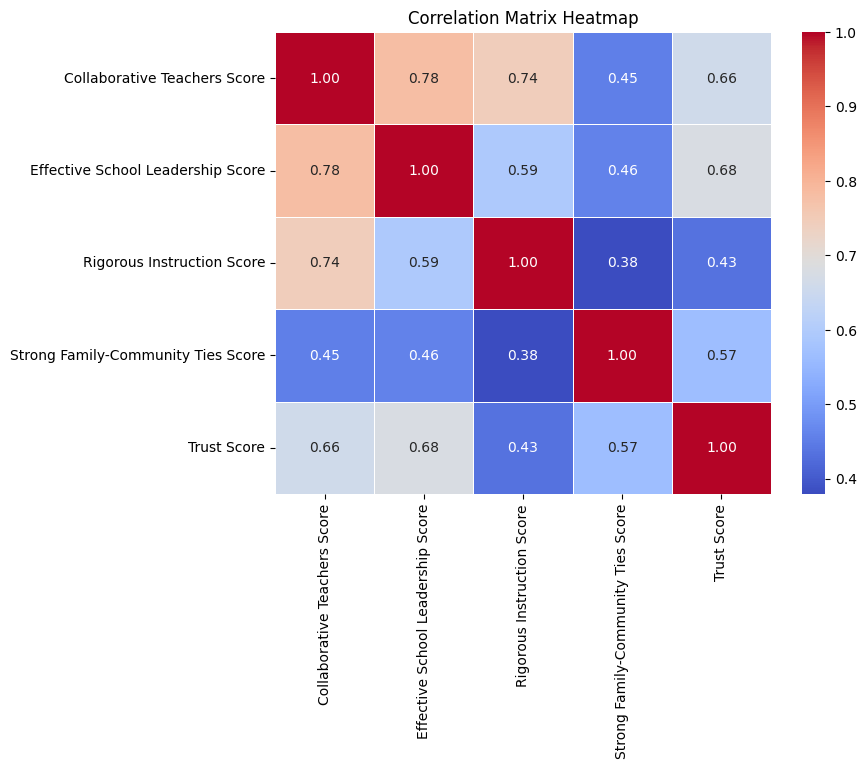

In [83]:
#heatmap for visualization purposes 
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

#### Linear Regression Models 

Summary <br>
- P-value matrix shows statisitically significant correlations between all varibales, except that variable and itself.
- There is a strong correlation between
  - Collaborative Teacher and Effective School Leadership
  - Collaborative Teacher and Rigorous Instruction
- For Trust Score of a school, there is 
  - moderate correlation with Collaborative Teacher Score
  - moderate correlation with Effective School Leadership
  - moderate-weak correlation with Rigorous Instruction
  - moderate-weak correlation with Strong Family-Community Ties

### Modelling

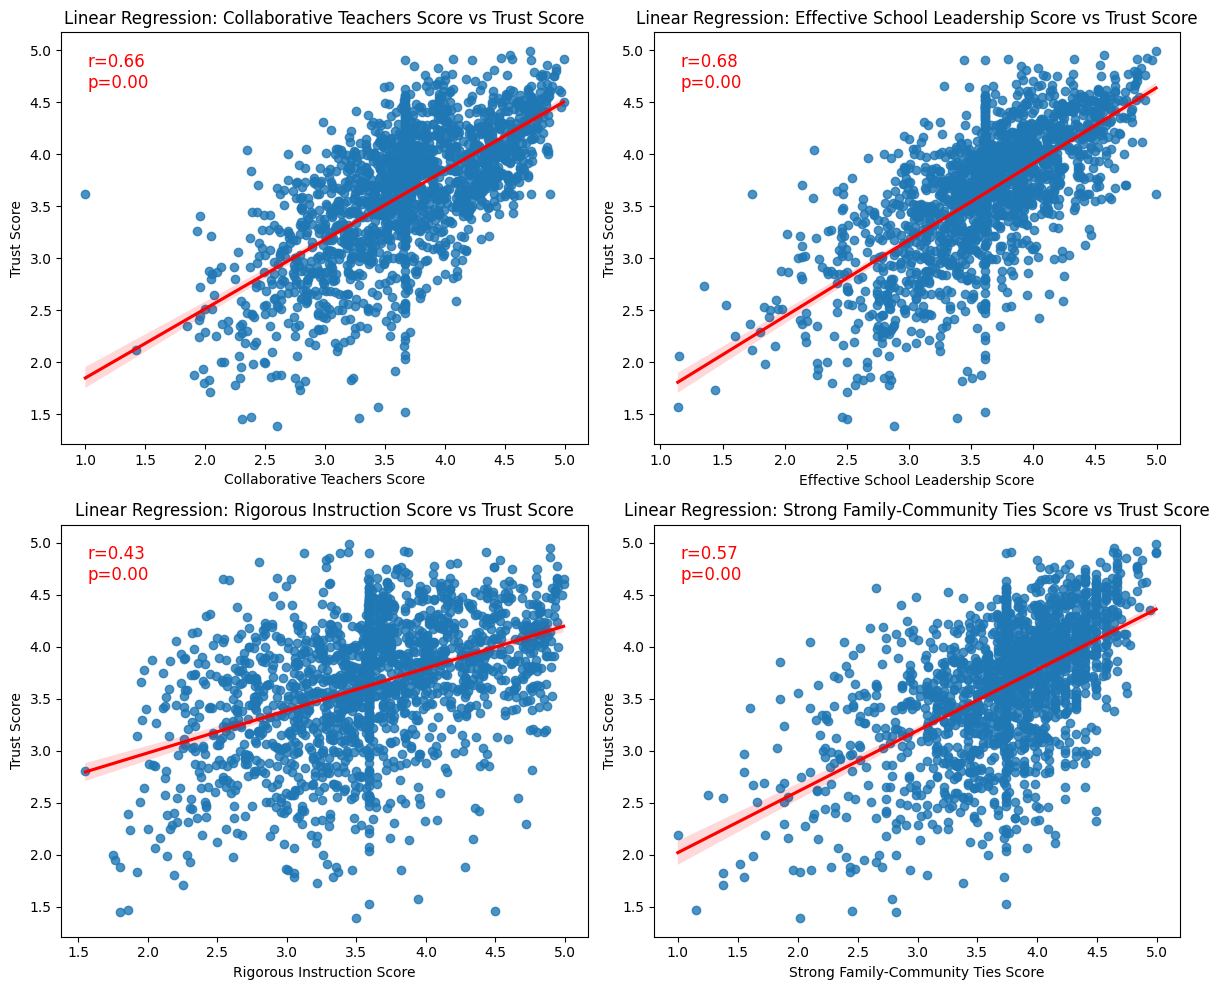

In [92]:
# List of independent variables to plot
x_vars = df.drop(df.columns[-1], axis=1)

# Create 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot each regression
for i, var in enumerate(x_vars):
    # Determine subplot position
    row, col = divmod(i, 2)  
    ax = axes[row, col]
    
    # get r and p value to display as text 
    r_value, p_value = pearsonr(df[var], df['Trust Score'])
    
    # plot regression 
    sns.regplot(x=df[var], y=df['Trust Score'], ax=ax, line_kws={"color": "red"})
    ax.text(0.05,0.95, f"r={r_value:.2f}\np={p_value:.2f}", 
            transform=ax.transAxes, fontsize=12, color="red", 
            verticalalignment='top')
    
    ax.set_title(f'Linear Regression: {var} vs Trust Score')

plt.tight_layout()
plt.show()

In [98]:
x_vars = df.drop(df.columns[-1], axis=1).columns
Y = df['Trust Score'] #series because target variable

for x_var in x_vars:
    X = df[[x_var]] #df
    lm = LinearRegression()
    lm.fit(X,Y)
    r2 = lm.score(X, Y)

    print(f"R2 score for {x_var} vs Trust Score: {r2:.4f}")
    

R2 score for Collaborative Teachers Score vs Trust Score: 0.4358
R2 score for Effective School Leadership Score vs Trust Score: 0.4605
R2 score for Rigorous Instruction Score vs Trust Score: 0.1892
R2 score for Strong Family-Community Ties Score vs Trust Score: 0.3196


R2 score measures how well a linear regression model explains the variability in the dependent variable (Y) using the independent variable (X).

According to the R2 scores above:
- Collaborative teacher and Effective School Leadership partially explain variance in Trust Score.
- Rigorous Instruction and Strong Family-Community Ties barely to does not explain variance in Trust Score.

In [113]:
X_multi = df[x_vars]
lm.fit(X_multi, Y)
r2_multi = lm.score(X_multi, Y)
print(f"Multiple linear regression r2 score is {r2_multi}")

Multiple linear regression r2 score is 0.5810763539911616


In [129]:
# Predict values
Y_pred = lm.predict(X_multi)

# Get coefficients and intercepts
coefficients = lm.coef_
intercept = lm.intercept_

print(f"Intercept (b0): {intercept}")
for i in range(len(coefficients)):
    print(f"{X_multi.columns[i]} : {coefficients[i]}")

Intercept (b0): 0.26963607786111377
Collaborative Teachers Score : 0.3821347665633454
Effective School Leadership Score : 0.3725582765931886
Rigorous Instruction Score : -0.15482111794061593
Strong Family-Community Ties Score : 0.31043381499557166


In [116]:
#Pipeline of polynomial regression with standardization
Input=[('scale',StandardScaler()),
       ('polynomial', PolynomialFeatures(include_bias=False)), #default degree of 2
       ('model',LinearRegression())]
pipeline = Pipeline(Input)
pipeline.fit(X_multi, Y)
poly_score = pipeline.score(X_multi,Y)
print(f"Polynomial regression pipeline r^2 score is {poly_score}")

Polynomial regression pipeline r^2 score is 0.5847746994615676


In [120]:
# Get Coefficients
X_multi_vars = ['X1', 'X2', 'X3', 'X4']
coefficients = pipeline.named_steps['model'].coef_
intercept = pipeline.named_steps['model'].intercept_

feature_names = pipeline.named_steps['polynomial'].get_feature_names_out(X_multi_vars)
coeff_dict = dict(zip(feature_names, coefficients))

print("Feature Coefficients:")
for feature, coef in coeff_dict.items():
    print(f"{feature}: {coef}")

Feature Coefficients:
X1: 0.2340200020623503
X2: 0.19810153912782041
X3: -0.09483992697994027
X4: 0.19538284954825685
X1^2: -0.03368281691652791
X1 X2: 0.06249454765379088
X1 X3: -0.0017036190234645705
X1 X4: -0.037484332630680836
X2^2: -0.0322000919521324
X2 X3: -0.005992463683523807
X2 X4: 0.018295636295154256
X3^2: 0.012048287647483107
X3 X4: -0.00858830531719713
X4^2: 0.013589121547978714


where X1 = Collaborative Teachers Score,
X2 = Effective School Leadership Score,
X3 = Rigorous Instruction Score,
X4 = Strong Family-Community Ties Score

### Model Refinement

In [ ]:
# TODO: changing polynomial coefficient 
# see if the train data is overfitted r2 of train >> r2 of test
# try applying lasso

In [132]:
# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_multi, Y, test_size=0.2, random_state=42)

In [133]:
# Try different polynomial degrees
degrees = range(1, 6)  # Testing degrees 1 to 5
train_r2_scores = []
test_r2_scores = []

for d in degrees:
    pipeline = Pipeline([
        ('scale', StandardScaler()), 
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),  
        ('model', LinearRegression())
    ])
    
    pipeline.fit(X_train, Y_train)
    
    # Compute R^2 scores
    train_r2 = pipeline.score(X_train, Y_train)
    test_r2 = pipeline.score(X_test, Y_test)
    
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    
    print(f"Degree {d}: Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}")

Degree 1: Train R² = 0.5729, Test R² = 0.6093
Degree 2: Train R² = 0.5762, Test R² = 0.6126
Degree 3: Train R² = 0.5892, Test R² = 0.6014
Degree 4: Train R² = 0.6021, Test R² = 0.6047
Degree 5: Train R² = 0.6228, Test R² = 0.5634


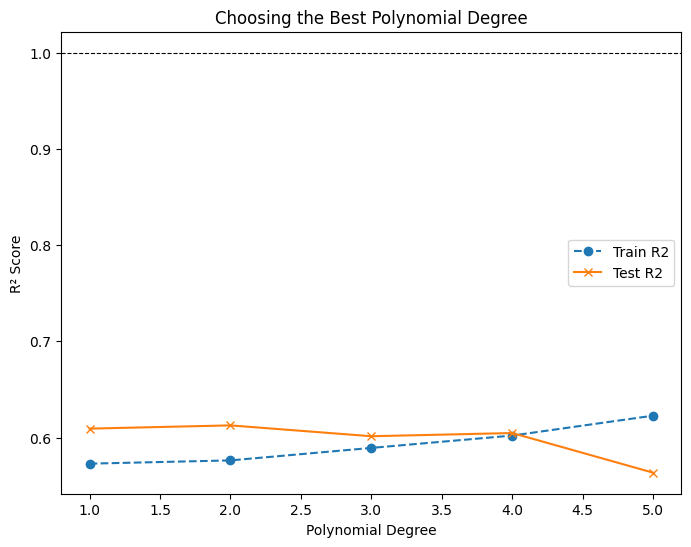

In [134]:
# Plot R2 scores
plt.figure(figsize=(8,6))
plt.plot(degrees, train_r2_scores, marker='o', label="Train R2", linestyle='--')
plt.plot(degrees, test_r2_scores, marker='x', label="Test R2", linestyle='-')
plt.axhline(y=1, color='black', linestyle='--', linewidth=0.8) 
plt.xlabel("Polynomial Degree")
plt.ylabel("R² Score")
plt.title("Choosing the Best Polynomial Degree")
plt.legend()
plt.show()

Train R² (0.5762) and test R² (0.6126) are close -> No major overfitting.<br>
Degree 3, 4, and 5 show signs of overfitting becayse train R² increases, test R² stagnates or drops.

In [154]:
# Use degree= 2 for Polynomial Regression Pipeline 
pipeline = Pipeline([
    ('scale', StandardScaler()),  
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  
    ('model', LinearRegression())
])
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [155]:
x_vars

Index(['Collaborative Teachers Score', 'Effective School Leadership Score',
       'Rigorous Instruction Score', 'Strong Family-Community Ties Score'],
      dtype='object')

In [156]:
# according to AI
X_range = np.tile(X_train.mean().values, (200, 1))  # create a 200 row table with mean values of each column
X_range[:, 0] = np.linspace(X_train['Collaborative Teachers Score'].min(), X_train['Collaborative Teachers Score'].max(), 200)  
X_range[:, 1] = np.linspace(X_train['Effective School Leadership Score'].min(), X_train['Effective School Leadership Score'].max(), 200)  
X_range[:, 2] = np.linspace(X_train['Rigorous Instruction Score'].min(), X_train['Rigorous Instruction Score'].max(), 200)  
X_range[:, 3] = np.linspace(X_train['Strong Family-Community Ties Score'].min(), X_train['Strong Family-Community Ties Score'].max(), 200)  

# Convert back to DataFrame for feature names
X_range_df = pd.DataFrame(X_range, columns=X_train.columns)

# Predict Y values for the polynomial curve
Y_pred = pipeline.predict(X_range_df)


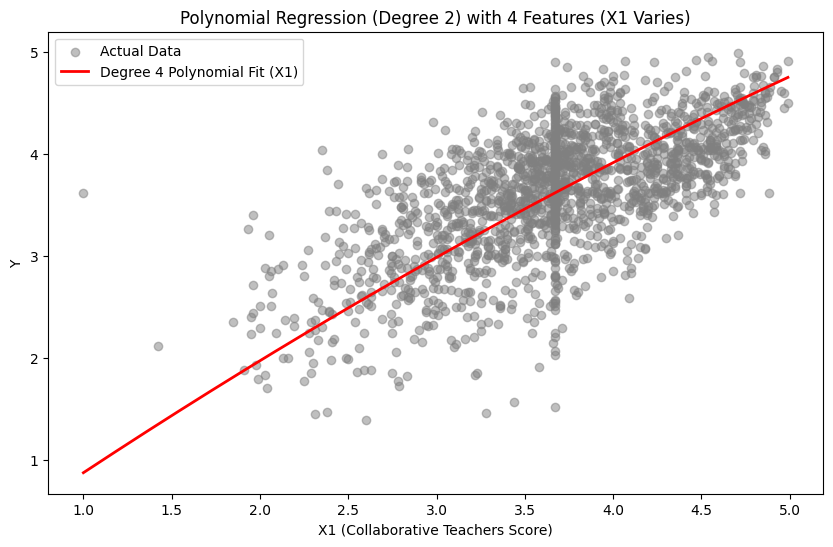

In [158]:
plt.figure(figsize=(10, 6))
plt.scatter(X_multi['Collaborative Teachers Score'], Y, color='gray', alpha=0.5, label="Actual Data")  # Scatter plot of original data
plt.plot(X_range_df['Collaborative Teachers Score'], Y_pred, color='red', linewidth=2, label="Degree 4 Polynomial Fit (X1)")  # Regression Curve
plt.xlabel("X1 (Collaborative Teachers Score)")
plt.ylabel("Y")
plt.title("Polynomial Regression (Degree 2) with 4 Features (X1 Varies)")
plt.legend()
plt.show()


In [160]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [165]:
# Make Predictions
Y_train_pred = pipeline.predict(X_train)  # Predict on training data
Y_test_pred = pipeline.predict(X_test)  # Predict on test data

# Evaluate Model Performance
train_r2 = r2_score(Y_train, Y_train_pred)
test_r2 = r2_score(Y_test, Y_test_pred)
mae = mean_absolute_error(Y_test, Y_test_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

print ("Final polynomial regression model (degree=2)")
print("\n")
print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Final polynomial regression model (degree=2)


Train R² Score: 0.5762
Test R² Score: 0.6126
Mean Absolute Error (MAE): 0.2952
Root Mean Squared Error (RMSE): 0.3946


### Model Refinement: Ridge

In [167]:
from sklearn.linear_model import Ridge

In [168]:
ridge = Pipeline([
    ('scale', StandardScaler()),  
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  
    ('model', Ridge(alpha=1.0))
])

In [169]:
# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_multi, Y, test_size=0.2, random_state=42)
ridge.fit(X_train, Y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('model', Ridge())])

In [171]:
Y_train_pred = ridge.predict(X_train)
Y_test_pred = ridge.predict(X_test)

In [172]:
train_r2 = r2_score(Y_train, Y_train_pred)
test_r2 = r2_score(Y_test, Y_test_pred)
mae = mean_absolute_error(Y_test, Y_test_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Train R² Score: 0.5762
Test R² Score: 0.6126
Mean Absolute Error (MAE): 0.2953
Root Mean Squared Error (RMSE): 0.3946


In [173]:
# change alpha value for regularization

In [174]:
from sklearn.linear_model import RidgeCV

# Test different alpha values
alphas = [0.01, 0.1, 1, 10, 100]

ridge_cv = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', RidgeCV(alphas=alphas, store_cv_values=True))
])

ridge_cv.fit(X_train, Y_train)

# Best alpha
best_alpha = ridge_cv.named_steps['ridge'].alpha_
print(f"Best Alpha: {best_alpha:.2f}")

/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Best Alpha: 10.00


In [177]:
ridge_10 = Pipeline([
    ('scale', StandardScaler()),  
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  
    ('model', Ridge(alpha=10.00))
])
ridge_10.fit(X_train, Y_train)
Y_train_pred_10 = ridge_10.predict(X_train)
Y_test_pred_10 = ridge_10.predict(X_test)

train_r2 = r2_score(Y_train, Y_train_pred_10)
test_r2 = r2_score(Y_test, Y_test_pred_10)
mae = mean_absolute_error(Y_test, Y_test_pred_10)
rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred_10))

print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Train R² Score: 0.5762
Test R² Score: 0.6119
Mean Absolute Error (MAE): 0.2958
Root Mean Squared Error (RMSE): 0.3950


### All Summaries

Summary of Variable Correlations <br>
- P-value matrix shows statisitically significant correlations between all varibales, except that variable and itself.
- There is a strong correlation between
  - Collaborative Teachers and Effective School Leadership
  - Collaborative Teachers and Rigorous Instruction
- For Trust Score of a school, there is 
  - moderate correlation with Collaborative Teachers Score
  - moderate correlation with Effective School Leadership
  - moderate-weak correlation with Rigorous Instruction
  - moderate-weak correlation with Strong Family-Community Ties

Summary of Predictive Statistics <br>

- Using a Polynomial Regression Model with degree = 2 and with alpha = 10.0 has a r^2 (correlation 